## Etapas iniciais na determinação do algoritmo de recomendação a ser utilizado
### - Análise exploratória inicial;
### - Teste com algoritmos.

## Sistema de recomendação utilizando o algoritmo SVD
#### site: https://www.kaggle.com/skillsmuggler/amazon-ratings?select=ratings_Beauty.csv

In [ ]:
# importando as bibliotecas
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import scipy
%matplotlib inline
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
!pip install surprise
from surprise.prediction_algorithms import SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from scipy.sparse.linalg import svds
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise.dataset import DatasetAutoFolds
from surprise import Trainset, Reader
from surprise.prediction_algorithms import matrix_factorization
from surprise.model_selection.split import KFold
from surprise.dataset import DatasetAutoFolds

     |████████████████████████████████| 11.8 MB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619401 sha256=7952ab4b0500c9432e5bd66553c1262391c3f7ef5e1030737fbb97d0e5c7f3a1
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# carregando a base de dados
from google.colab import files
uploaded=files.upload()
import io

Saving df.csv to df.csv


In [ ]:
# carregando o data frame
df = pd.read_csv('df.csv')
df.head()

,Unnamed: 0,UserId,ProductId,Rating,Timestamp
0,507422,A2ASY5QOIS5FD6,B0011DFZ5U,5.0,1362614400
1,1906313,A2GFOYY2BNXVGZ,B00DCF7QW0,3.0,1403136000
2,667550,A3RN9X9IHIMU1D,B001ECQ59S,5.0,1228780800
3,1124377,A1EW3Y5YYDW7HD,B003XNYHWS,5.0,1365206400
4,690619,AOIYD5LQQOH63,B001FOR8AU,5.0,1260403200


In [ ]:
# verificando os tipos de dados
df.dtypes

Unnamed: 0      int64
UserId         object
ProductId      object
Rating        float64
Timestamp       int64
dtype: object

In [ ]:
# transformando a coluna 'Rating' em inteiro
df['Rating'].astype('int64')

507422     5
1906313    3
667550     5
1124377    5
690619     5
          ..
36066      1
1550495    5
1540753    4
1331034    5
999652     2
Name: Rating, Length: 500, dtype: int64

In [ ]:
# estabelecendo uma amostra do data frame 
df = df.sample(n=500)

In [ ]:
df.to_csv('df.csv')

## Análise exploratória

In [ ]:
# número de linhas e colunas
df.shape

(500, 4)

In [ ]:
# tipos de dados
df.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp      int64
dtype: object

In [ ]:
# resumo da coluna 'Rating'
df.describe()['Rating']

count    2.023070e+06
mean     4.149036e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
# Menor e maior avaliações
print('A menor avaliação é: %d' %(df.Rating.min()))
print('A maior avaliação é: %d' %(df.Rating.max()))

A menor avaliação é: 1
A maior avaliação é: 5


In [ ]:
# checando valores faltantes
df.isnull().sum()

Unnamed: 0    0
UserId        0
ProductId     0
Rating        0
Timestamp     0
dtype: int64

In [ ]:
# analisando as avaliações
n_ratings = len(df)
n_users = df['UserId'].nunique()
n_product = df['ProductId'].nunique()
n_users_ratings = n_ratings/n_users
n_product_ratings = n_ratings/n_product

print('Número de avaliações: {}'.format(n_ratings))
print('Número de usuários: {}'.format(n_users))
print('Número de produtos: {}'.format(n_product))
print('Média de avaliações por usuário: {}'.format(n_users_ratings))
print('Média de avaliações por produto: {}'.format(n_product_ratings))

Número de avaliações: 2023070
Número de usuários: 1210271
Número de produtos: 249274
Média de avaliações por usuário: 1.6715842980621696
Média de avaliações por produto: 8.115848423822781


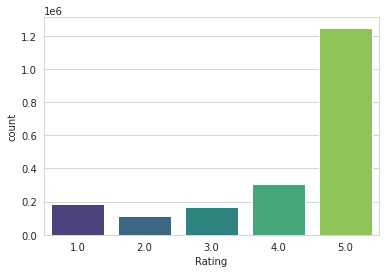

In [ ]:
# verificando a distribuição das avaliações dos produtos
sns.set_style('whitegrid')
ax = sns.countplot(x='Rating', data=df, palette='viridis')

In [ ]:
# geração da matriz esparsa
user = df['UserId'].nunique()
product = df['ProductId'].nunique()
#u = user.set_index(u)
#u = len(user)
#p = len(product)
sparse = csr_matrix(df['Rating'])

In [ ]:
# gerando uma tabela pivot
matriz_rating = df.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
matriz_rating.head()

ProductId,B000052XZX,B0000632EN,B00006FRW7,B00008ZPGA,B0000AR85Y,B0000YUXI0,B0000ZHOEU,B00014WW38,B000194XYE,B00021DGTE,B00021PALG,B00028OSHG,B00028PDWK,B0002FAGDY,B0002JKPA4,B0002Z0U5I,B0002Z0UA8,B0002Z8QG8,B00070QF20,B0007CWVLM,B0007L04J4,B0009953JA,B00099XJZU,B0009EXOO6,B0009MHJS0,B0009OAFUM,B0009OAHC8,B0009OAI18,B0009R3470,B000AA2XQ4,B000AQF50Y,B000ASDGK8,B000AU9PEC,B000BNG4VU,B000C1UBHE,B000C1VTQ6,B000C1W44M,B000C1Z6VA,B000C1ZDTU,B000C1ZEY4,...,B00D7MZ224,B00DCF7QW0,B00DDD3OB8,B00E16V7LU,B00E421ZDQ,B00E96XELS,B00EEBHS6U,B00EMJXVQK,B00F54IZAI,B00FEZAAWE,B00FS6SHUQ,B00FY153N4,B00FZBMT1M,B00G052NFE,B00G2TQNZ4,B00G4SDPHC,B00G75X158,B00GCH3PM0,B00GCQMSVA,B00GEH65UC,B00GMIXWTU,B00GMWMMOC,B00GNA9W4G,B00GOZBVO4,B00GQI67KW,B00GRPRRL2,B00GTBZ85Q,B00GTC02LA,B00H6QIRK6,B00HB94OJG,B00HG4N60O,B00HRJGI94,B00HSS8M7U,B00IALDHDI,B00ICSYV0M,B00IH49VBU,B00INB4HZW,B00KL0HV56,B00KQVTX06,B00KWFDBKE
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A10RZEU5A88MZ2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A10UH6NKDBE2Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A10ZZ8Q4OU3NVK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A1135PX892QSWB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A114ILTQXMOQ13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
matriz_rating.shape

(500, 492)

## Testando o algoritmo KNN
### - Documentação disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
#### https://aman-makwana101932.medium.com/understanding-recommendation-system-and-knn-with-project-book-recommendation-system-c648e47ff4f6
#### https://www.aurigait.com/blog/recommendation-system-using-knn/

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine')
knn.fit(sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
knn.fit(matriz_rating) # treino da matriz pivot
matriz2 = np.ravel(matriz_rating) # transformação em 1D
ind = np.random.choice(matriz2) # escolha aleatória de indices
index = matriz_rating.iloc[ind,:].values.reshape(1,-1) # coletando os indices e transformando em array 2D
distances, indices = knn.kneighbors(index, n_neighbors = 5)

In [ ]:
# definindo uma função de recomendação
def suggest(pivot, n_neighbors):
  pivot = df.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
  knn = NearestNeighbors(metric='cosine')
  knn.fit(pivot)
  matriz = np.ravel(pivot)
  ind = np.random.choice(matriz)
  index = pivot.iloc[ind,:].values.reshape(1,-1)
  distances, indices = knn.kneighbors(index, n_neighbors = 5)
  for prod in range(0, len(distances)):
            
    return print('Recomendação para {0}: \n'.format(pivot.iloc[indices[prod]], distances[prod]))

In [ ]:
def suggest2(sparse, n_neighbors):
  sparse = sparse = csr_matrix(df['Rating'])
  knn = NearestNeighbors(metric='cosine')
  knn.fit(sparse)
  matriz = np.ravel(sparse)
  ind = np.random.choice(matriz)
  ind = ind.reshape(1,-1)
  index = sparse.iloc[ind,:].values.reshape(1,-1)
  distances, indices = knn.kneighbors(index, n_neighbors = 5)
  for User in range(0, len(distances)):
            
    return print('Recomendação para {0}: \n'.format(sparse.iloc[indices[User]], distances[User]))

In [ ]:
#pivot = matriz_rating
#User = 'A1135PX892QSWB'
#matriz = matriz
prod = 'B000052XZX'
suggest(pivot, 5)

Recomendação para ProductId       B000052XZX  B0000632EN  ...  B00KQVTX06  B00KWFDBKE
UserId                                  ...                        
A10RZEU5A88MZ2           0           0  ...           0           0
A3KGPSWJCJGQBN           0           0  ...           0           0
A3KLB13HPB7RVW           0           0  ...           5           0
A3KMSEPAEV96AT           0           0  ...           0           0
A3JN2LFHRDMYVC           0           0  ...           0           0

[5 rows x 492 columns]: 



## Testando a biblioteca Surprise (específica para modelos de recomendação)
#### - Documentação disponível em: https://surprise.readthedocs.io/en/stable/

In [ ]:
import pickle
from surprise.dump import dump

In [ ]:

def train_model(csv):
  print('read csv and train the model, grid search is optional')
  csv = Dataset.load_from_df(csv[['UserId', 'ProductId', 'Rating']], Reader(rating_scale=(1,5)))
  algo = SVD()
  #model_grid = GridSearchCV(algo, param_grid={'n_epochs': (3,5,10,50,100), 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}, cv=5, measures='rmse')
  cross_validate(algo, csv, cv=5)
  train_set = csv.build_full_trainset()
  model = algo.fit(train_set)
  return model

def save_model(model):
  with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)  
  # nome auto gerado
  # file_name = 'c3256d66-e1cb-45fa-8ccd-c39355466c03.model'
  file_name = str(uuid.uuid4()) + '.model'
  print('model')
  return file_name

def load_model(model_filename):
  with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
  print('something like model = something.load(file_name)')
  return model

def predict(csv, model):
  print('something model.predict([product_id])')
  csv = Dataset.load_from_df(csv[['UserId', 'ProductId', 'Rating']], Reader(rating_scale=(1,5)))
  trainset = csv.build_full_trainset()
  testset = trainset.build_testset()
  model = algo.fit(trainset)
  predicoes = model.test(testset)  
  return predicoes

def get_top_n(csv, model, n=10):
  csv = Dataset.load_from_df(csv[['UserId', 'ProductId', 'Rating']], Reader(rating_scale=(1,5)))
  trainset = csv.build_full_trainset()
  testset = trainset.build_testset()
  model = algo.fit(trainset)
  predicoes = model.test(testset)
  top_n = defaultdict(list)
  for uid, iid, true_r, est, _ in predicoes:
    top_n[uid].append((iid,est))
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:n]
  for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
  return top_n


In [ ]:
import uuid
save_model(algo)


model


'b5e4e770-feb6-4d3c-9e06-0a06e532af40.model'

In [ ]:
train_model(df)

read csv and train the model, grid search is optional


In [ ]:
load_model(algo)

something like model = something.load(file_name)


In [ ]:
predict(df, algo)

In [ ]:
from collections import defaultdict
get_top_n(df, algo)

A3VR7BMTOWZGF3 ['B003K76XO2']
A84SIUM0F6E8H ['B00AHGSDDS']
A2XUUISIIHYOCU ['B003ZZL830']
A2MMPT80UF1K2Z ['B00A0RHULK']
A12LN1UTGCPU4R ['B0002DM5GC']
A3DOGYD0FRJH6Y ['B00C066U2E']
AYBFEU7CMLV5R ['B001551OIG']
A13WJ4T4MPZ5E4 ['B00F0BKEC8']
A300GUSDAHJL9P ['B003TQPRGY']
A1KCC71B5HZY7F ['B005GQ6F4I', 'B00AHH00MO']
AGNRUU09261OD ['B001H928KI']
A3CPYV1EEB9L5H ['B00905V3SE']
A2S29B2CM3F5RA ['B00A917LKM']
A1KQ6Z445AGKQL ['B003EMIX8W']
A2DG4QOKG1JITC ['B008HRXR5I']
A3GGKOW9018635 ['B002JPJ2ZS']
A3KQNTNPNRUH1 ['B000C1VXM6']
A3S6NVNBV32ZMV ['B00CAW7SD8']
A5P4GNZS13HT9 ['B002HZ00OW']
A20XI285MM8PEB ['B008N3HXTW']
A1WQ9VYNAQZ14R ['B00099E8ZA']
A3PL599D5EBYJN ['B001JQLNNC']
A3Z3DLUEF29D1 ['B0010B2OSY']
A3IN4Y5L2MG732 ['B000052YM7']
A3BWPULHZ8G9MJ ['B00IT69F62']
A3TS7N6EX9OVFU ['B007OCI34C']
AR2JR7B5Y14OC ['B004W1P6GG']
A3FOQQJHPT01TG ['B000XE6FS4']
A1FTFWS66HSHRD ['B004BHAJAE']
A17H3ZRZKKWQJH ['B0009V1YR8']
A1VVGDGYJFBWJY ['B001E96NIE']
AKPHF7BQUECWJ ['B008HODSNW']
A3CM3U7S2N710F ['B0009V8N4U']
AHR6

defaultdict(list,
            {'A1044N2MIMQ1C5': [('B008U1Q4DI', 4.141762180246356)],
             'A10E7OCHR7XR04': [('B0006MSVCG', 4.4792689842255475)],
             'A10WUYUDNTD2Q8': [('B001ECQ4VW', 4.508279964418733)],
             'A1177LTKWTA24B': [('B00IBG5K4Q', 4.432483251523798)],
             'A11FQ84IUOXAE9': [('B0085YAR7Y', 4.558074884444302)],
             'A11PQ040N8IFQJ': [('B0000535CH', 4.431797887923776)],
             'A11R0JP8N1A14B': [('B00005O0MZ', 4.483835804883679)],
             'A11R9DNW0G9MO7': [('B00CQ58LHG', 3.045136939351372)],
             'A11TKHCI3Y6JVL': [('B00GGMAXPS', 4.355700932880514)],
             'A11UFQD8KDKL1U': [('B001I45ZFC', 4.551463612137729)],
             'A125A036JNKBIO': [('B001FYV0HM', 4.467318842895327)],
             'A129IZ4GSHYVL4': [('B000HEECYY', 4.392116406080442)],
             'A12HW49ALN7MDO': [('B000JUV816', 4.44427146546266)],
             'A12LN1UTGCPU4R': [('B0002DM5GC', 4.32793906581636)],
             'A12WXTZ2QY9ZJX': 

In [ ]:
svd = SVD()
svd_grid = GridSearchCV(svd, param_grid={'n_epochs': (3,5,10,50,100), 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}, cv=5, measures='rmse')

In [ ]:
# validação cruzada 5 folds
val = cross_validate(svd, df, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(val)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2481  1.2497  1.2504  1.2496  1.2481  1.2492  0.0009  
MAE (testset)     0.9756  0.9774  0.9777  0.9775  0.9758  0.9768  0.0009  
Fit time          116.55  117.57  116.76  116.77  116.64  116.86  0.36    
Test time         5.12    6.01    4.82    5.01    5.02    5.19    0.42    
{'test_rmse': array([1.24813836, 1.24973494, 1.25039803, 1.2495763 , 1.24809316]), 'test_mae': array([0.97556582, 0.97744746, 0.97769056, 0.97752889, 0.97579704]), 'fit_time': (116.5535831451416, 117.56656885147095, 116.76027488708496, 116.76870036125183, 116.64015007019043), 'test_time': (5.117762327194214, 6.010310173034668, 4.824401378631592, 5.006500720977783, 5.015293598175049)}


In [ ]:
# criando o dataset de treino
trainset = df.build_full_trainset()

In [ ]:
# treinando o algoritmo SVD
svd.fit(train_set)

In [ ]:
# realizando predições para todos os pares user x product que não estão no dataset de treino
test_set = trainset.build_anti_testset()
predictions = algo.test(test_set)

In [ ]:
def get_top_n(predictions, n=10):
  top_n = defaultdict(list)
  for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid,est))
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:n]
  return top_n

*Implementação* de algoritmo de sugestão: definir interface das funções: receber arquivo csv, salvar modelo (arquivo em disco), carregar modelo e predição

In [ ]:
def train_model(csv):
  print('Carregando a base de dados')
  csv = Dataset.load_from_df(csv[['UserId', 'ProductId', 'Rating']], Reader(rating_scale=(1,5)))
  print('Ok')
  algo = SVD()
  cross_validate(algo, csv, cv=5)
  #gs = GridSearchCV(SVD, param_grid={'n_epochs': (3,5,10,50,100), 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}, cv=5, measures='rmse', refit=True)
  print('Criando o dataset de treino')
  trainset = csv.build_full_trainset()
  print('Ok')
  print('Iniciando o treinamento dos dados')
  modelo = algo.fit(trainset)
  #params_treino = gs.best_params['rmse']
  #print('Melhores parâmetros: \t', gs.best_params['rmse'])
  print('Finalizado')
  return modelo
  

def save_model(modelo):
  file_name = 'Modelo final.pickle'
  pickle.dump(algo, open(file_name, 'wb'))
  print(file_name)
  return file_name

def load_model(file_name):
  print('Carregando o modelo')
  loaded_model = pickle.load(open(file_name, 'rb'))
  print ("Modelo carregado")
  return loaded_model

def predicoes(csv, modelo, n=5):
  print('Realizando as predições')
  model_loaded = load_model(file_name='Modelo final.pickle')
  csv = Dataset.load_from_df(csv[['UserId', 'ProductId', 'Rating']], Reader(rating_scale=(1,5)))
  trainset = csv.build_full_trainset()
  testset = trainset.build_testset()
  predicoes = model_loaded.test(testset)
  top_n = defaultdict(list)
  for uid, iid, true_r, est, _ in predicoes:
    top_n[uid].append((iid,est))
  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:n]
  for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
  return top_n
  


In [ ]:
train_model(df)

read csv and train the model, grid search is optional


In [ ]:
save_model(modelo)

In [ ]:
load_model('Modelo final.pickle')

Carregando o modelo
Modelo carregado


In [ ]:
predicoes(df, algo)

Realizando as predições
Carregando o modelo
Modelo carregado
A3VR7BMTOWZGF3 ['B003K76XO2']
A84SIUM0F6E8H ['B00AHGSDDS']
A2XUUISIIHYOCU ['B003ZZL830']
A2MMPT80UF1K2Z ['B00A0RHULK']
A12LN1UTGCPU4R ['B0002DM5GC']
A3DOGYD0FRJH6Y ['B00C066U2E']
AYBFEU7CMLV5R ['B001551OIG']
A13WJ4T4MPZ5E4 ['B00F0BKEC8']
A300GUSDAHJL9P ['B003TQPRGY']
A1KCC71B5HZY7F ['B005GQ6F4I', 'B00AHH00MO']
AGNRUU09261OD ['B001H928KI']
A3CPYV1EEB9L5H ['B00905V3SE']
A2S29B2CM3F5RA ['B00A917LKM']
A1KQ6Z445AGKQL ['B003EMIX8W']
A2DG4QOKG1JITC ['B008HRXR5I']
A3GGKOW9018635 ['B002JPJ2ZS']
A3KQNTNPNRUH1 ['B000C1VXM6']
A3S6NVNBV32ZMV ['B00CAW7SD8']
A5P4GNZS13HT9 ['B002HZ00OW']
A20XI285MM8PEB ['B008N3HXTW']
A1WQ9VYNAQZ14R ['B00099E8ZA']
A3PL599D5EBYJN ['B001JQLNNC']
A3Z3DLUEF29D1 ['B0010B2OSY']
A3IN4Y5L2MG732 ['B000052YM7']
A3BWPULHZ8G9MJ ['B00IT69F62']
A3TS7N6EX9OVFU ['B007OCI34C']
AR2JR7B5Y14OC ['B004W1P6GG']
A3FOQQJHPT01TG ['B000XE6FS4']
A1FTFWS66HSHRD ['B004BHAJAE']
A17H3ZRZKKWQJH ['B0009V1YR8']
A1VVGDGYJFBWJY ['B001E96NIE']
AK

defaultdict(list,
            {'A1044N2MIMQ1C5': [('B008U1Q4DI', 4.141762180246356)],
             'A10E7OCHR7XR04': [('B0006MSVCG', 4.4792689842255475)],
             'A10WUYUDNTD2Q8': [('B001ECQ4VW', 4.508279964418733)],
             'A1177LTKWTA24B': [('B00IBG5K4Q', 4.432483251523798)],
             'A11FQ84IUOXAE9': [('B0085YAR7Y', 4.558074884444302)],
             'A11PQ040N8IFQJ': [('B0000535CH', 4.431797887923776)],
             'A11R0JP8N1A14B': [('B00005O0MZ', 4.483835804883679)],
             'A11R9DNW0G9MO7': [('B00CQ58LHG', 3.045136939351372)],
             'A11TKHCI3Y6JVL': [('B00GGMAXPS', 4.355700932880514)],
             'A11UFQD8KDKL1U': [('B001I45ZFC', 4.551463612137729)],
             'A125A036JNKBIO': [('B001FYV0HM', 4.467318842895327)],
             'A129IZ4GSHYVL4': [('B000HEECYY', 4.392116406080442)],
             'A12HW49ALN7MDO': [('B000JUV816', 4.44427146546266)],
             'A12LN1UTGCPU4R': [('B0002DM5GC', 4.32793906581636)],
             'A12WXTZ2QY9ZJX': 